## Import Library

In [67]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [68]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [69]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

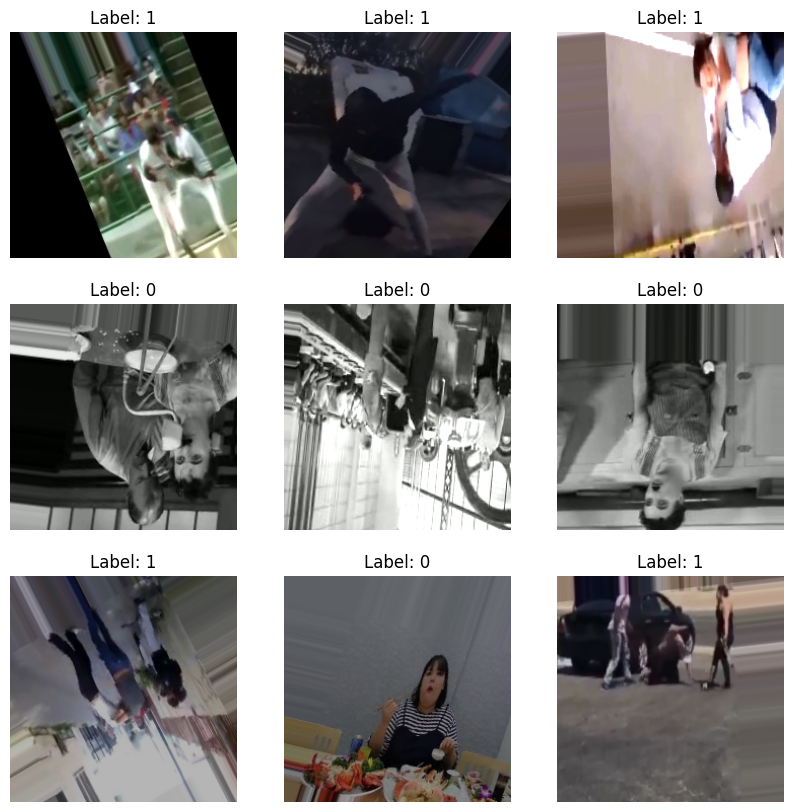

In [70]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [71]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# All Freeze
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_AllFreeze_0.01.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [72]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6715 - loss: 1.3734
Epoch 1: val_accuracy improved from -inf to 0.63409, saving model to NoMCLAHE_AllFreeze_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 673ms/step - accuracy: 0.6722 - loss: 1.3721 - val_accuracy: 0.6341 - val_loss: 1.3804
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.7727 - loss: 1.0559
Epoch 2: val_accuracy did not improve from 0.63409
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 620ms/step - accuracy: 0.7727 - loss: 1.0543 - val_accuracy: 0.6205 - val_loss: 1.0290
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7951 - loss: 0.8476
Epoch 3: val_accuracy improved from 0.63409 to 0.78182, saving model to NoMCLAHE_AllFreeze_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 625ms/step - accuracy: 0.7948 - loss: 0.8475 - val_accuracy: 0.7818 - val_loss: 0.7700
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.7975 - loss: 0.7958
Epoch 4: val_accuracy did not improve from 0.78182
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 629ms/step - accuracy: 0.7973 - loss: 0.7957 - val_accuracy: 0.5614 - val_loss: 1.1772
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7884 - loss: 0.8296
Epoch 5: val_accuracy did not improve from 0.78182
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 616ms/step - accuracy: 0.7888 - loss: 0.8301 - val_accuracy: 0.6909 - val_loss: 1.1932
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7971 - loss: 0.8488
Epoch 6: val_accuracy improved from 0.78182 to 0.80000, saving model to NoMCLAHE_AllFreeze_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 619ms/step - accuracy: 0.7969 - loss: 0.8484 - val_accuracy: 0.8000 - val_loss: 0.7238
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8025 - loss: 0.7345
Epoch 7: val_accuracy did not improve from 0.80000
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 616ms/step - accuracy: 0.8022 - loss: 0.7356 - val_accuracy: 0.6818 - val_loss: 1.0531
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8148 - loss: 0.7453
Epoch 8: val_accuracy did not improve from 0.80000
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 617ms/step - accuracy: 0.8147 - loss: 0.7453 - val_accuracy: 0.7045 - val_loss: 0.9699
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8302 - loss: 0.7199
Epoch 9: val_accuracy did not improve from 0.80000
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 618ms/step - accuracy: 0.8299 - loss: 0.7203 - val_accuracy: 0.7500 - val_loss: 0.7780
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7760 - loss: 0.8392
Epoch 10: val_accuracy improve

49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 621ms/step - accuracy: 0.7764 - loss: 0.8390 - val_accuracy: 0.8250 - val_loss: 0.7707
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8190 - loss: 0.8353
Epoch 11: val_accuracy did not improve from 0.82500
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 636ms/step - accuracy: 0.8191 - loss: 0.8350 - val_accuracy: 0.6977 - val_loss: 1.1312
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7696 - loss: 0.8365
Epoch 12: val_accuracy did not improve from 0.82500
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 617ms/step - accuracy: 0.7700 - loss: 0.8360 - val_accuracy: 0.7773 - val_loss: 0.9167
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8018 - loss: 0.8625
Epoch 13: val_accuracy did not improve from 0.82500
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 623ms/step - accuracy: 0.8021 - loss: 0.8619 - val_accuracy: 0.8159 - val_loss: 0.7541
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8058 - loss: 0.8017
Epoch 14: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 619ms/step - accuracy: 0.8269 - loss: 0.7077 - val_accuracy: 0.8545 - val_loss: 0.6780
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8253 - loss: 0.7658
Epoch 18: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 615ms/step - accuracy: 0.8251 - loss: 0.7658 - val_accuracy: 0.7636 - val_loss: 0.8009
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8062 - loss: 0.7263
Epoch 19: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 614ms/step - accuracy: 0.8064 - loss: 0.7261 - val_accuracy: 0.7864 - val_loss: 0.7433
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8277 - loss: 0.6574
Epoch 20: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 617ms/step - accuracy: 0.8276 - loss: 0.6577 - val_accuracy: 0.7614 - val_loss: 0.8598
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8018 - loss: 0.7005
Epoch 21: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 621ms/step - accuracy: 0.7749 - loss: 0.7964 - val_accuracy: 0.8568 - val_loss: 0.5537
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8072 - loss: 0.7140
Epoch 28: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.8069 - loss: 0.7146 - val_accuracy: 0.8364 - val_loss: 0.7312
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8256 - loss: 0.7497
Epoch 29: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.8254 - loss: 0.7498 - val_accuracy: 0.8364 - val_loss: 0.6378
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8139 - loss: 0.6979
Epoch 30: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 618ms/step - accuracy: 0.8137 - loss: 0.6983 - val_accuracy: 0.6523 - val_loss: 1.0788
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.8063 - loss: 0.7143
Epoch 31: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.3862 - loss: 1.6260
Validation Loss: 1.1195399761199951
Validation Accuracy: 0.625


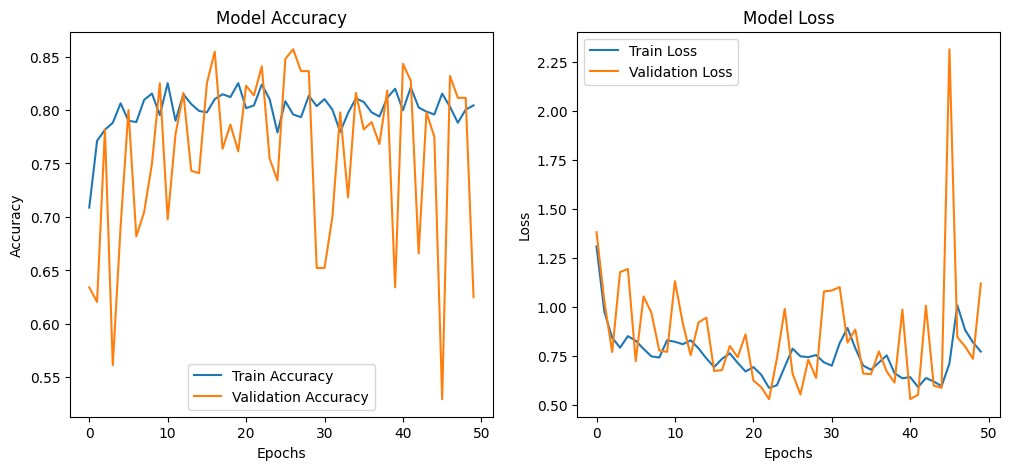

In [73]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [74]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_AllFreeze_0.01.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.8059 - loss: 0.6231
Test Accuracy : 86.49%
Test Loss     : 0.545


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


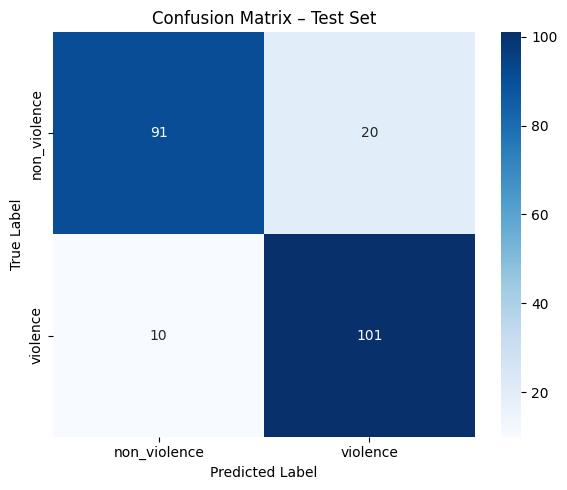


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.90      0.82      0.86       111
    violence       0.83      0.91      0.87       111

    accuracy                           0.86       222
   macro avg       0.87      0.86      0.86       222
weighted avg       0.87      0.86      0.86       222



In [75]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))